# Research Question

In June of 2022 the US Supreme Court revoked the constitutional right to an abortion in the Dobbs vs Women’s
Health of Jackson case. One possible impact of this law is that women without access to a safe abortion may leave
the labor force due to pregnancy and childcare responsibilities. I would like to empirically measure these
potential labor force impacts of abortion access.

## (i) Approach

Difference-in-Differences is an appropriate identification strategy in this case to compare labor force outcomes before and after the Dobbs decision across states with different abortion policies, under the assumption that in the absence of the decision, trends in labor force of the states would have been parallel.

## (ii) Select states

To implement Diff-in-Diffs, I need to pick states that are near each other, are likely to have
similar economies, and have very different policies on abortion access. Utilizing this excellent
interactive map on abortion policy created by the Guttmacher Institute. I select two groups of states which I think would be useful to compare.

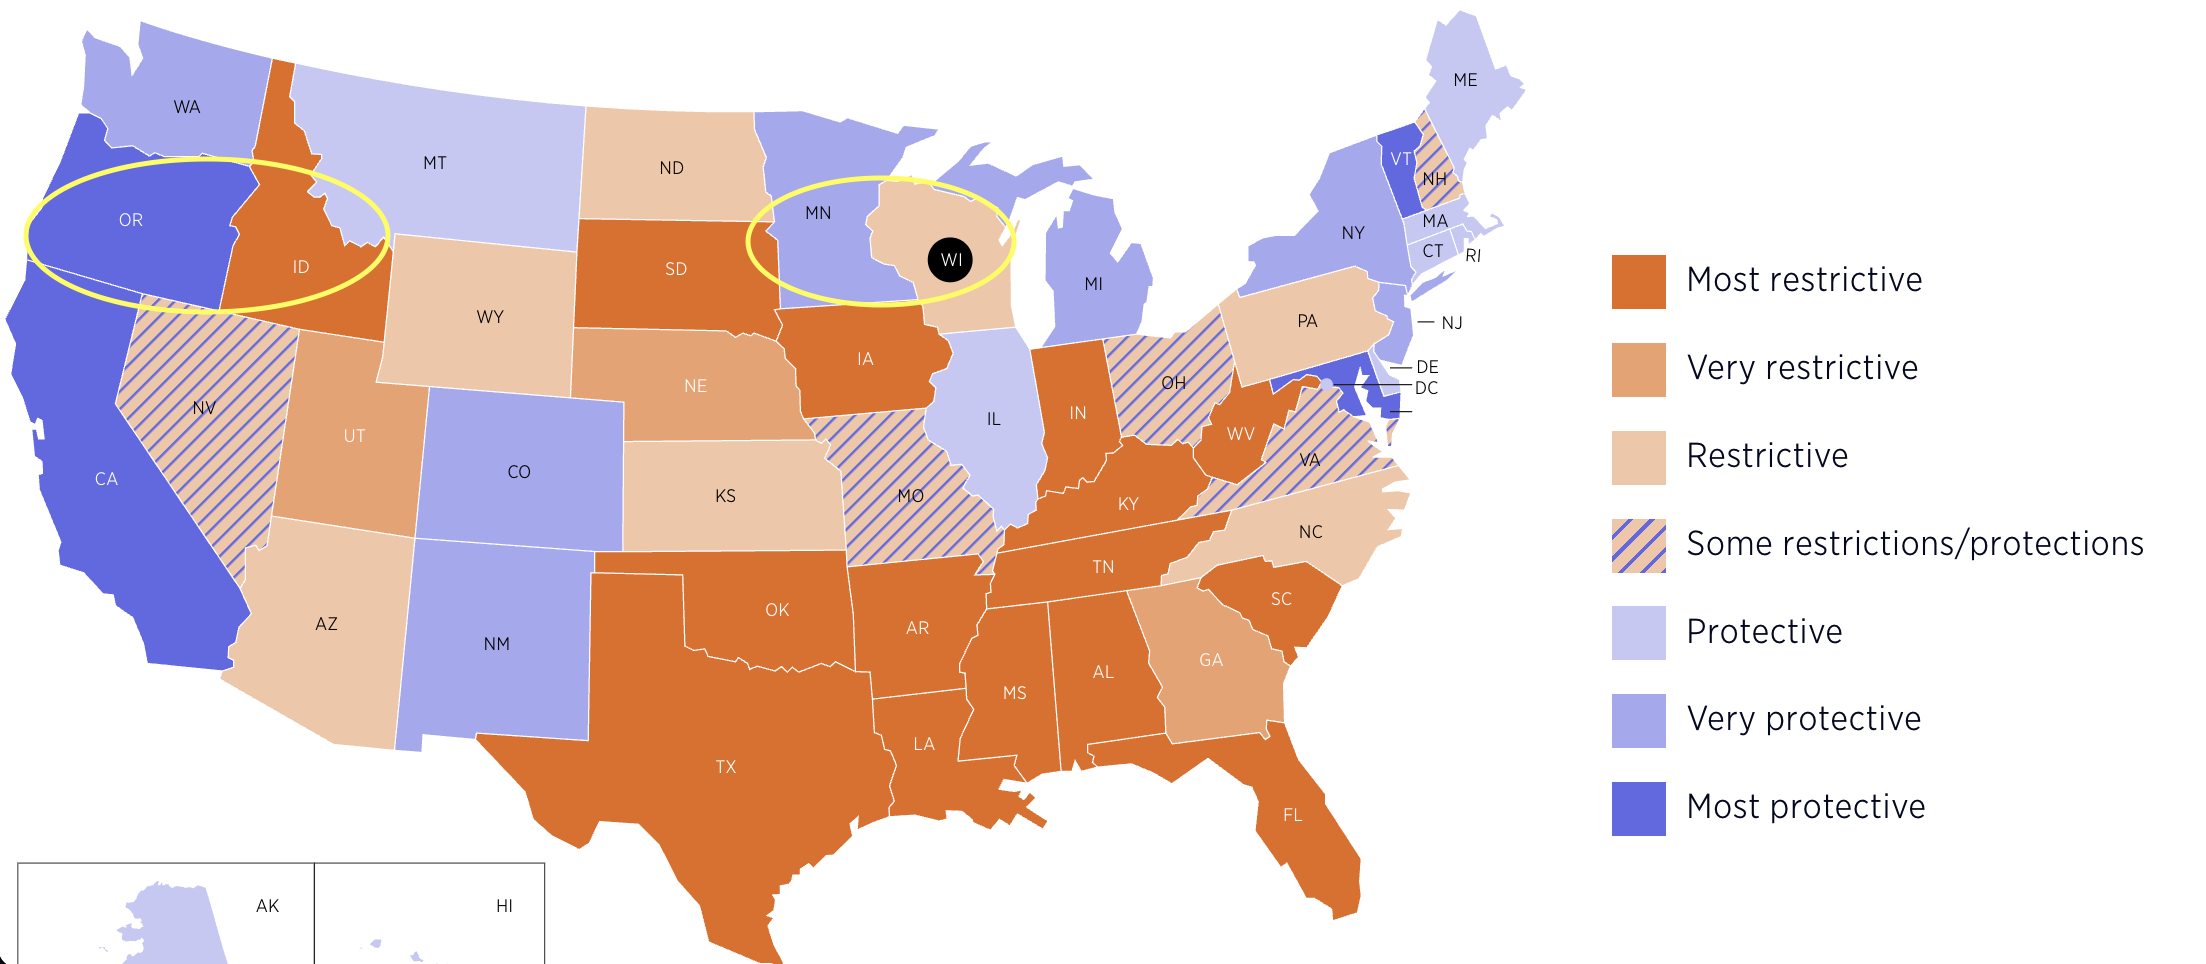

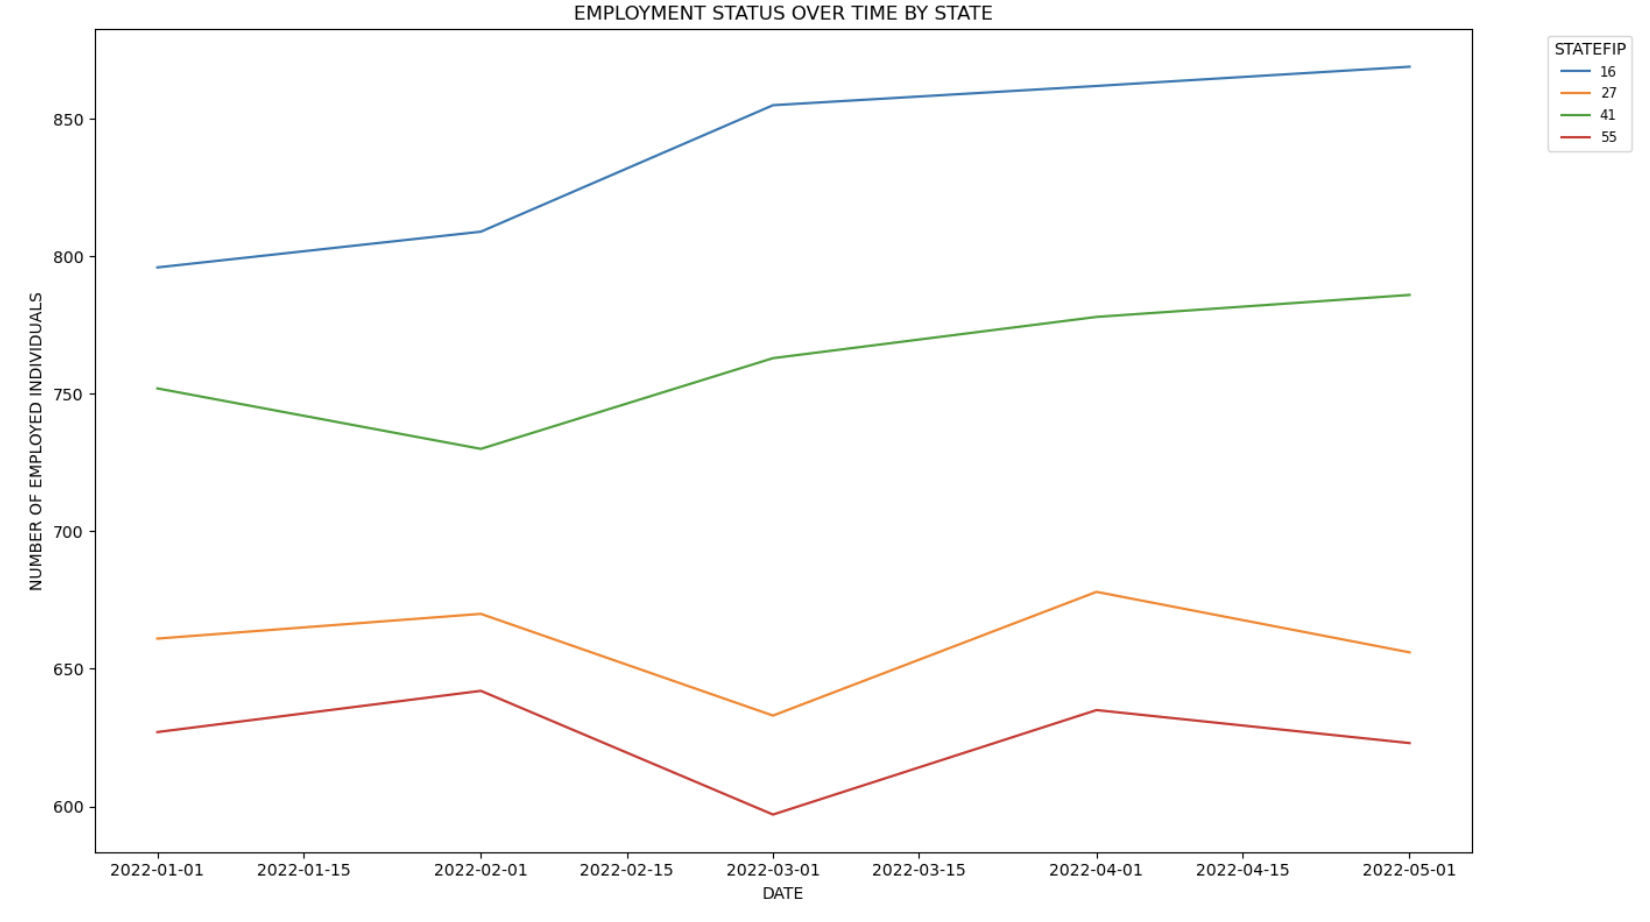

**Selections:**

I considered two different pairs: Idaho/Oregon and Minnesota/Wisconsin since they are very similar in slopes in the pre-Dobbs periods. 

16: Idaho | 27: Minnesota | 41: Oregon  | 55: Wisconsin

- Strict abortion laws (treatment group): **Wisconsin & Idaho**
- Protective abortion laws (control group): **Minnesota & Oregon**

**Reasons:**

- They're geographically close, hence, likely to have similar economies.
- Post-Dobbs policies:
     - **Wisconsin & Idaho**'s abortion policies are restrictive. 
     - **Minnesota & Oregon**'s abortion policies are protective.

**Assumptions:**

- Parallel Trends Assumption: Labor force in both states followed similar trends before June 2022. (Shown in graphs)
- No Spillover Effects: Women in Idaho or Wisconsin didn’t move to neighboring states Oregon or Minnesota to access abortion and work there.
- No Other Simultaneous Shocks: No major unrelated labor policy change that disproportionately affected one state over the other in the same time frame.

## (iii) Import data

I prepared a data set containing monthly data on state, employment status, sex, and age from the Current Population Survey (CPS) between January 2020 and March 2024.

Note: These data and much more can be accessed from IPUMS CPS with a free account. The
relevant employment variable is called empstat.

In [2]:
import pandas as pd
import numpy as np

In [8]:
data = pd.read_csv('../data/cps_00003.csv')
data.head()

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,ASECWTH,STATEFIP,PERNUM,WTFINL,CPSIDP,CPSIDV,ASECWT,AGE,SEX,EMPSTAT
0,2020,1,1,1686.4805,20181200000100,NaN,NaN,1,1,1771.3809,20181200000101,201812000001011,NaN,69,1,36
1,2020,1,1,1686.4805,20181200000100,NaN,NaN,1,2,1686.4805,20181200000102,201812000001021,NaN,65,2,36
2,2020,2,1,2048.1802,20191100000100,NaN,NaN,1,1,2048.1802,20191100000101,201911000001011,NaN,54,1,32
3,2020,2,1,2048.1802,20191100000100,NaN,NaN,1,2,3013.7016,20191100000102,201911000001021,NaN,21,1,10
4,2020,2,1,2048.1802,20191100000100,NaN,NaN,1,3,1730.9391,20191100000103,201911000001031,NaN,48,2,10


In [9]:
# Limit to the states we want to study
# 16: Idaho | 27: Minnesota | 41: Oregon  | 55: Wisconsin
df = data.copy()
df = df[df['STATEFIP'].isin([41, 27, 16, 55])]

## (iv) Data preparation

Load this CSV into your software of choice. Limit your sample to working aged individuals, ages 15 to
64. The outcome we would like to study is whether or not someone was at work during the week the
survey was conducted. Based on the codebook created with your data export, generate a dummy
variable that captures this. Also generate a dummy variable for female. Finally, generate a dummy
variable for being in the state(s) with the more strict abortion laws, which you can call strict.

In [120]:
# Select relevant columns
df = df[['YEAR', 'MONTH', 'STATEFIP', 'AGE', 'SEX', 'EMPSTAT']]

# Limit to ages 15 to 64 
df = df[(df['AGE'] >= 15) & (df['AGE'] <= 64)]

df.head()

,YEAR,MONTH,STATEFIP,AGE,SEX,EMPSTAT
33646,2020,1,16,52,1,10
33647,2020,1,16,50,2,10
33649,2020,1,16,23,1,10
33650,2020,1,16,23,2,10
33652,2020,1,16,57,1,32


In [121]:
# Dummy: female
df['FEMALE'] = df['SEX'].apply(lambda x: 1 if x == 2 else 0)

# Dummy: strict abortion law state (Idaho)
df['STRICT'] = df['STATEFIP'].apply(lambda x: 1 if x in [16, 55] else 0)  # 16 is Idaho, 55 is Wisconsin

# Dummy: working = 1 if EMPSTAT == 10 (At work), else 0
df['WORKING'] = df['EMPSTAT'].apply(lambda x: 1 if x == 10 else 0) # 10 is At work

df.head()

,YEAR,MONTH,STATEFIP,AGE,SEX,EMPSTAT,FEMALE,STRICT,WORKING
33646,2020,1,16,52,1,10,0,1,1
33647,2020,1,16,50,2,10,1,1,1
33649,2020,1,16,23,1,10,0,1,1
33650,2020,1,16,23,2,10,1,1,1
33652,2020,1,16,57,1,32,0,1,0


## (v) Define Pre/Post Time Periods

To estimate a Diff-in-Diffs regression, you’ll need to construct pre and post time periods using your monthly data. The ruling removing constitutional abortion rights was on June 24, 2022. Use January through May of 2022 as your pre period, and January through May of 2023 as your post period.
Generate the variable post to distinguish these periods in your data.

In [122]:
# Create 'date' column from YEAR and MONTH
df['date'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))

# Filter for January–May of 2022 and 2023 only
df = df[
    ((df['YEAR'] == 2022) & (df['MONTH'].between(1, 5))) |
    ((df['YEAR'] == 2023) & (df['MONTH'].between(1, 5)))
]

# Create the post variable: 1 if Jan–May 2023, 0 otherwise
df['POST'] = df['date'].apply(lambda d: 1 if '2023-01' <= d.strftime('%Y-%m') <= '2023-05' else 0)

# Drop date column 
df = df.drop('date', axis=1)

df

,YEAR,MONTH,STATEFIP,AGE,SEX,EMPSTAT,FEMALE,STRICT,WORKING,POST
2904950,2022,1,16,43,1,10,0,1,1,0
2904953,2022,1,16,55,1,34,0,1,0,0
2904957,2022,1,16,59,2,12,1,1,0,0
2904958,2022,1,16,57,1,12,0,1,0,0
2904959,2022,1,16,33,2,12,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
4591310,2023,5,55,42,1,10,0,1,1,1
4591311,2023,5,55,41,2,10,1,1,1,1
4591315,2023,5,55,27,2,10,1,1,1,1
4591318,2023,5,55,52,2,10,1,1,1,1


In [123]:
# Sanitary check
df[['STATEFIP', 'YEAR', 'MONTH']].drop_duplicates().sort_values(['STATEFIP','YEAR', 'MONTH'])

,STATEFIP,YEAR,MONTH
2904950,16,2022,1
3007405,16,2022,2
3109693,16,2022,3
3210972,16,2022,4
3315163,16,2022,5
4101571,16,2023,1
4200781,16,2023,2
4298070,16,2023,3
4394592,16,2023,4
4494489,16,2023,5


## (vi) DiD regression

Write down the Diff-in-Diffs regression model that captures the impact of strict abortion laws on
working status. Explain which coefficient captures this treatment effect and why.
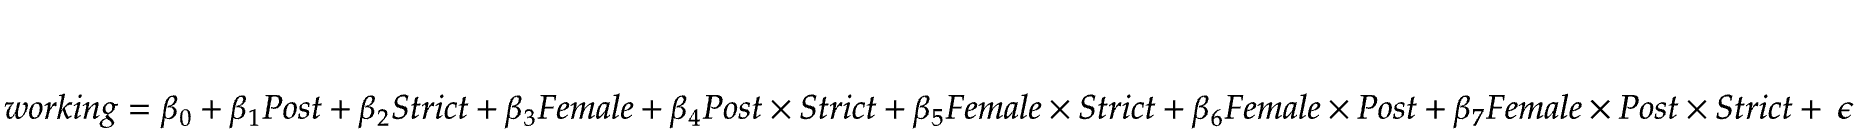

- $\beta_0$: The intercept.
- $\beta_1$: The slope of the control group.
- $\beta_2$: The intercept difference of the treatment group.
- $\beta_3$: The intercept difference of being female.
- $\beta_4$: Interaction between living in a strict state after the Dobbs decision - the slope difference of a strict state affected differently post Dobbs decision.
- $\beta_5$: Interaction between being female and living in a strict state — the slope difference of women in strict states are affected differently than men.
- $\beta_6$: Interaction between being female after the Dobbs decision — the slope difference of women are affected differently than men after the Dobbs decision.
- $\beta_7$: The main DiD interaction, the treatment effect — the slope difference of women in strict states after the Dobbs decision are differently impacted compared to men or women in non-strict states.

## (vii) Estimate the model

Estimate this regression model in your data using the variables that you have created. Only include
women in your regression, and use heteroskedasticity robust standard errors. Include this output in
your submission. 

Since we only include women in our dataset, our regression can be simplied to:

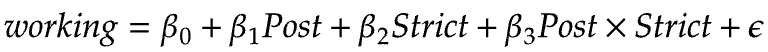

In [124]:
import statsmodels.formula.api as smf

# Filter the data to include only women
df_women = df[df['FEMALE'] == 1]

# Fit the OLS regression model with heteroskedasticity-robust standard errors
model = smf.ols('WORKING ~ STRICT + POST + STRICT:POST', data=df_women).fit(cov_type='HC3')

# Print the regression summary with robust standard errors
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                WORKING   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.989
Date:                Fri, 11 Apr 2025   Prob (F-statistic):            0.00185
Time:                        22:43:34   Log-Likelihood:                -12743.
No. Observations:               19418   AIC:                         2.549e+04
Df Residuals:                   19414   BIC:                         2.553e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6915      0.007    105.289      

## (viii) Interpretation

Interpret the magnitude and statistical significance of the treatment effect you estimated. Assuming this is a causal parameter, offer your best economic story explaining the results: i.e. “Women worked more/less after the ruling in strict abortion law states because XYZ”.

**Results:**
- **$\beta_3$ (`0.0136`)**: After the Dobbs decision, women in **strict abortion state such as Idaho & Wisconsin** were **1.36 percentage points more likely** to be working compared to women in the non-strict state such as **Oregon and Minnesota**, relative to the pre-Dobbs difference.  
- **p-value (`0.311`)**: Very high, meaning the effect is **not statistically significant** at any common critical levels 5%, 10%..
  
Assuming this is causal, the positive coefficient suggests **an increase in employment** for women in strict states post-Dobbs. But because the estimate is **not statistically significant**, we cannot confidently say that the Dobbs decision had an effect on women’s labor force participation. This suggests there is no clear evidence of a labor force participation change caused by the policy, at least not in the states studied.

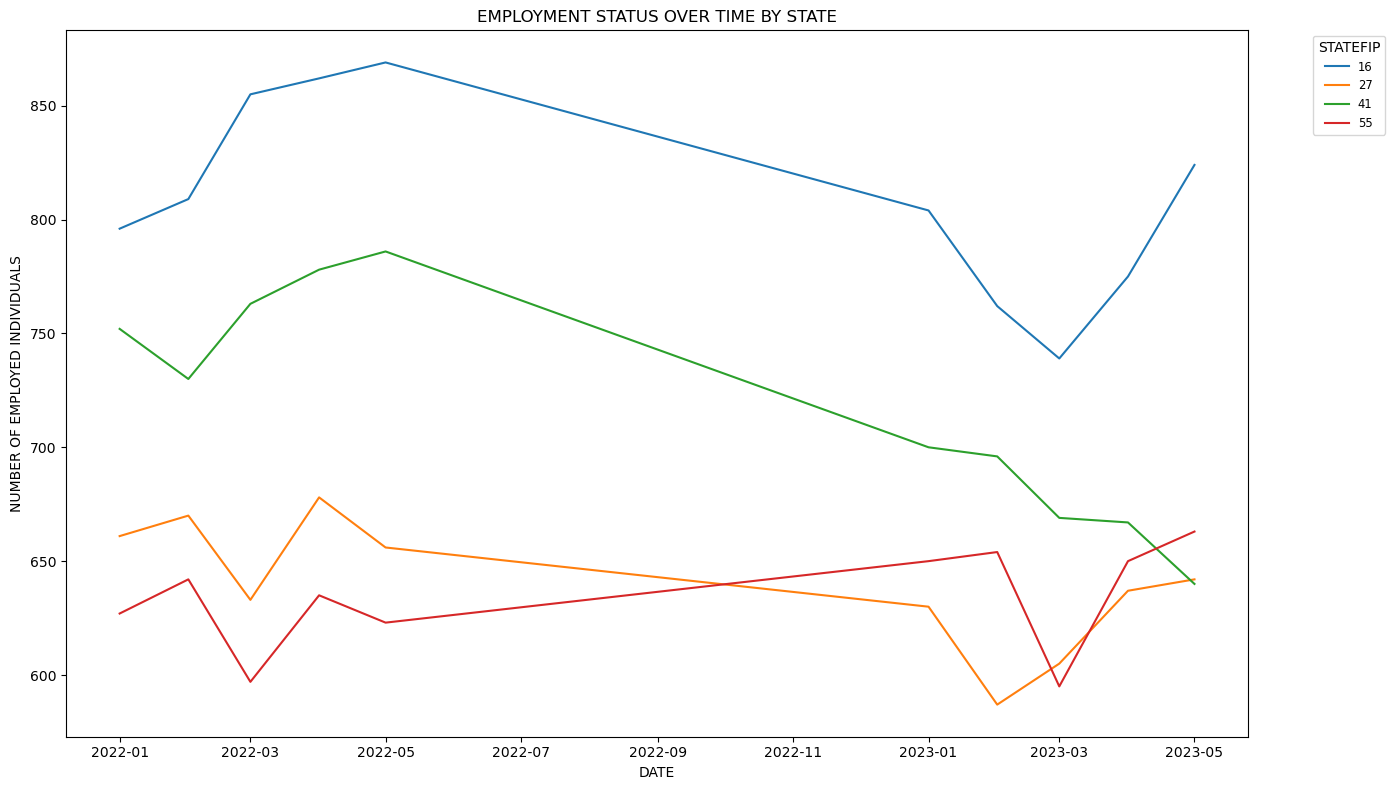

In [125]:
# Labor force trends Pre and Post Dobbs decisions

df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))

# Group by DATE and STATEFIP, then count EMPSTAT occurrences
grouped = df.groupby(['DATE', 'STATEFIP'])['EMPSTAT'].value_counts().unstack().fillna(0)

# Use the numeric code 10 (Employed) if EMPSTAT is stored as int
employed_over_time = grouped[10].unstack().T.sort_index(axis=1)  # Rows = STATEFIP, Columns = DATE

# Plotting
plt.figure(figsize=(14, 8))
for statefip in employed_over_time.index:
    plt.plot(employed_over_time.columns, employed_over_time.loc[statefip], label=statefip)

plt.title('EMPLOYMENT STATUS OVER TIME BY STATE')
plt.xlabel('DATE')
plt.ylabel('NUMBER OF EMPLOYED INDIVIDUALS')
plt.legend(title='STATEFIP', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()